# Optimization of Insurance Services and Customer Data Protection

The insurance company Sure Tomorrow wants to solve several tasks using machine learning and asks you to evaluate this possibility.
- Task 1: Find customers who are similar to a specific customer. This will help the company's agents with marketing.
- Task 2: Predict the probability that a new customer will receive an insurance benefit. Can a predictive model perform better than a dummy model?
- Task 3: Predict the number of insurance benefits that a new customer may receive using a linear regression model.
- Task 4: Protect customers' personal data without affecting the previous exercise's model. It is necessary to develop a data transformation algorithm that makes it difficult for personal information to be recovered if it falls into the wrong hands. This is called data masking or obfuscation. However, the data must be protected in such a way that it does not affect the quality of machine learning models. It is not necessary to choose the best model; just demonstrate that the algorithm works correctly.

# Initialization

In [454]:
# Load libraries

# Data manipulation
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

# Modeling
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

# Evaluation
from sklearn.metrics import f1_score, mean_squared_error, r2_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display
from IPython.display import display


# Load data

In [455]:
# Load the data into DataFrames
df = pd.read_csv('../datasets/insurance_us.csv')

# Prepare data

In [456]:
# Rename columns
df = df.rename(
    columns={
        'Gender': 'gender',
        'Age': 'age',
        'Salary': 'income',
        'Family members': 'family_members',
        'Insurance benefits': 'insurance_benefits',
    }
)

In [457]:
# Print the general/summary information about the DataFrame
df.info()

# Print a random sample of 10 rows from the DataFrame
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,gender,age,income,family_members,insurance_benefits
2084,0,29.0,34800.0,0,0
4942,0,31.0,47300.0,1,0
1619,1,27.0,43800.0,2,0
2649,1,29.0,38800.0,5,0
4361,1,20.0,34100.0,0,0
1682,0,41.0,36100.0,1,0
2028,1,26.0,54400.0,1,0
4432,0,50.0,39000.0,1,2
1301,1,20.0,52300.0,1,0
1488,1,36.0,51000.0,3,0


In [458]:
# Change the data type of age (from float to int)
df['age'] = df['age'].astype('int')

# Make sure the change has been applied
df['age'].dtype

dtype('int64')

In [459]:
# Take a look at the descriptive statistics of the data
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Observations

- `Gender`: Coded as 0 or 1, which typically represents a binary categorization like male/female or similar. The mean is very close to 0.5, indicating a nearly even split in the dataset.
- `Age`: Ranges from 18 to 65 years, with an average age of about 31 years. The standard deviation of approximately 8.44 years suggests that the majority of customers are within a 16- to 48-year range (mean +/- one standard deviation).
- `Income`: Varies from 5,300 to 79,000, with an average income of approximately 39,916 and a standard deviation of 9,900, indicating a moderate spread around the mean income.
- `Family Members`: Ranges from 0 to 6, with an average of about 1.19 family members. This suggests that single individuals or couples without children might be a common demographic in the dataset.
- `Insurance Benefits`: The number of insurance benefits claimed ranges from 0 to 5, with most customers (75th percentile) having claimed none. This implies that claims are not very frequent among the customers.

Overall, the dataset appears to have no missing values, outliers, or unusual data.

# EDA

We are going to quickly check if certain customer groups exist by observing the scatter plot.

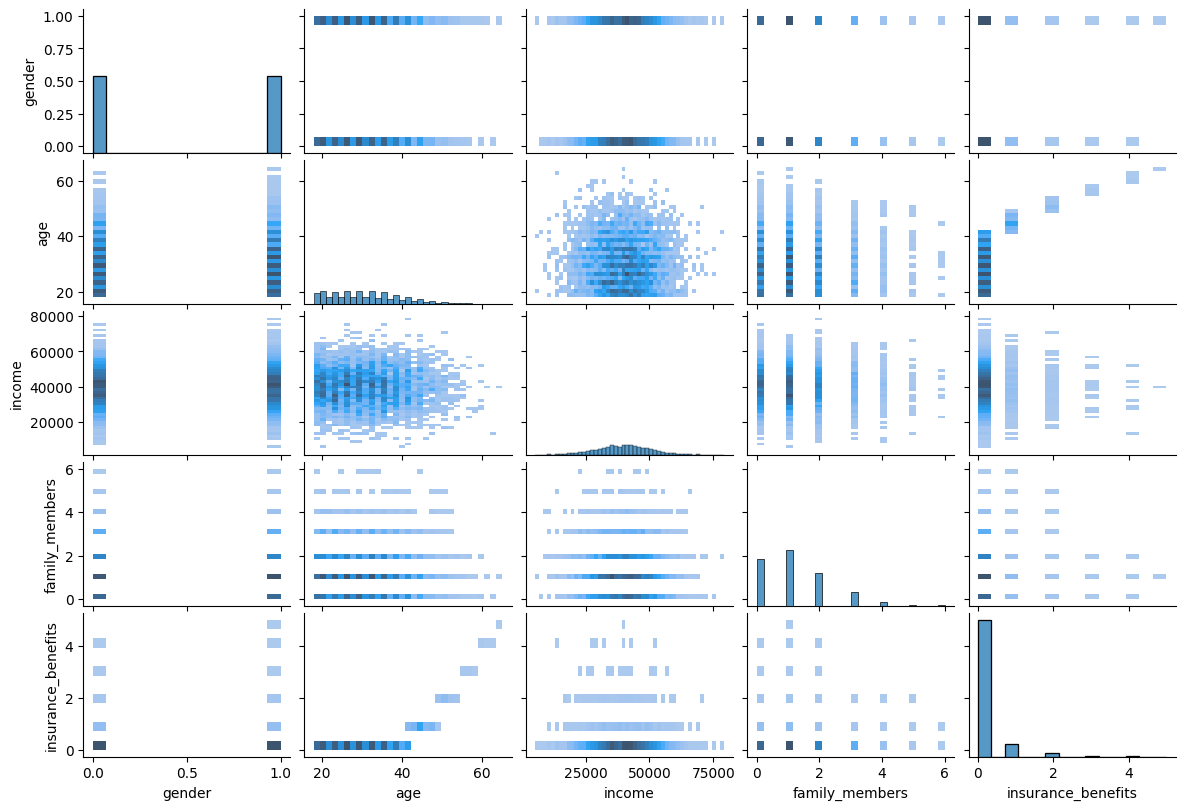

In [460]:
# Create a pairplot of the data with histograms along the diagonal
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 8)

## Observations

- **`Histograms`**
    - `Gender`: There appears to be an even distribution between the two gender categories.
    - `Age`: The age distribution appears right-skewed, indicating a younger customer base. Most customers are between 20 and 40 years old.
    - `Income`: The income distribution is concentrated around 30,000 to 50,000, with a few outliers on the higher end. The data seems to be slightly right-skewed, which means there are more customers with income below the mean than above it.
    - `Family Members`: The number of family members is mostly 0, 1, or 2, with very few having more than 4. This suggests that single individuals or small families are predominant in this customer base.
    - `Insurance Benefits`: A large majority of customers have not claimed any insurance benefits, with a very small number claiming more than one.
- **`Scatter Plots`**
    - `Age and Insurance Benefits`: It appears that older customers are slightly more likely to have insurance benefits, although the majority of customers, regardless of age, have not claimed insurance benefits.

**NOTE:** All other scatter plots do not show clear trends or patterns.

# Task 1. Similar Clients

In [461]:
# Create a function to get the KNN (k-nearest neighbors)
def get_knn(df, feature_names, n, k, metric):
    """
    Finds the k nearest neighbors of the nth object in a pandas DataFrame.

    Parameters:
        df: pandas DataFrame used to find similar objects within the same location
        feature_names: List of feature names to use for finding similar objects
        n: Index of the object for which to find the nearest neighbors
        k: Number of nearest neighbors to return
        metric: Name of the distance metric

    Returns:
        pandas DataFrame with the distance to the k nearest neighbors (distance column)
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors(df.iloc[[n]][feature_names], k, return_distance=True)


    return pd.concat(
        [
            df.iloc[nbrs_indices[0]],
            pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance']),
        ],
        axis=1,
    )

## Scaling data

In [462]:
# Create a list of features
feature_names = ['gender', 'age', 'income', 'family_members']

# MaxAbsScaler transformation
transformer_mas = MaxAbsScaler().fit(df[feature_names].to_numpy())

# Transform the chosen features
df_scaled = df.copy()
df_scaled[feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

# Print a random sample of 5 rows from the DataFrame
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3079,0.0,0.600000,0.340506,0.833333,0
881,0.0,0.384615,0.564557,0.333333,0
4171,1.0,0.723077,0.555696,0.333333,1
3334,1.0,0.569231,0.393671,0.166667,0
380,1.0,0.415385,0.670886,0.166667,0


## KNN (k-nearest neighbors)

In [463]:
# Get the 5 nearest neighbors for the object with index 0 (the first object)
k = 5
index = 0

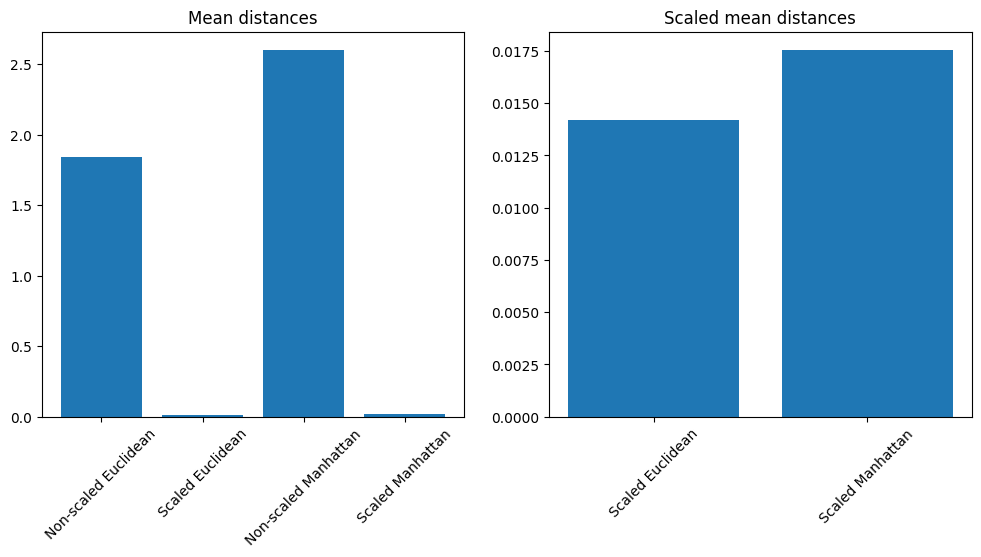

In [464]:
# Using the Euclidean distances
non_scaled_euclidean = get_knn(df, feature_names, index, k, 'euclidean')['distance'].mean()
scaled_euclidean = get_knn(df_scaled, feature_names, index, k, 'euclidean')['distance'].mean()

# Using the Manhattan distances
non_scaled_manhattan = get_knn(df, feature_names, index, k, 'manhattan')['distance'].mean()
scaled_manhattan = get_knn(df_scaled, feature_names, index, k, 'manhattan')['distance'].mean()

# Create two subplots, one for all mean distances and one for only the scaled mean distances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the mean distances
ax1.bar(
    ['Non-scaled Euclidean', 'Scaled Euclidean', 'Non-scaled Manhattan', 'Scaled Manhattan'],
    [non_scaled_euclidean, scaled_euclidean, non_scaled_manhattan, scaled_manhattan],
)
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Mean distances')

# Plot the scaled mean distances
ax2.bar(
    ['Scaled Euclidean', 'Scaled Manhattan'],
    [scaled_euclidean, scaled_manhattan],
)
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_title('Scaled mean distances')

plt.show()


## Intermediate Conclusion

- **Does the fact that the data is not scaled affect the kNN algorithm? If so, how does it manifest?**

Yes, the fact that the data is not scaled significantly affects the k-NN algorithm. When the data is not scaled, features with larger value ranges have a disproportionate weight in determining distance.

- **How similar are the results when using Manhattan distance metric (regardless of scaling)?**

The mean Euclidean distance is lower than the mean Manhattan distance. This is expected because, by definition, the Euclidean distance is generally less than or equal to the Manhattan distance due to the way they are calculated (straight-line distance vs. sum of absolute differences along each axis).

# Task 2. Is it likely that the client will receive an insurance benefit?

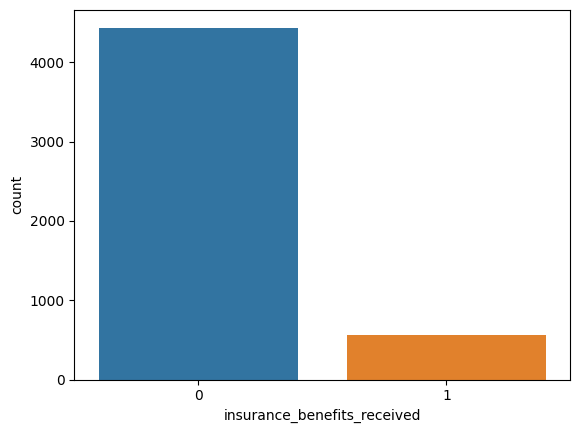

In [465]:
# Calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')

# Create a graph to visualize the class imbalance
sns.countplot(x='insurance_benefits_received', data=df)
plt.show()

## Observations

- The data is imbalanced, indicating a class imbalance with `0` being more common than `1`.

In [466]:
# Create function to evaluate the model predictions using the F1 score and confusion matrix
def eval_classifier(target, predictions, graph_confusion_matrix=False):
    """Evaluate the predictions of a binary classifier."""

    # Calculate the F1 score
    f1 = f1_score(target, predictions)
    if not graph_confusion_matrix:
        return f1

    # Calculate the confusion matrix and plot it
    cm = confusion_matrix(target, predictions, normalize='all')
    plt.figure(figsize=(2, 2))
    plt.title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f1, cm

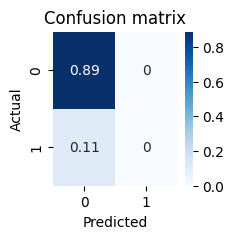

Probability: 0.00
F1 score: 0.00



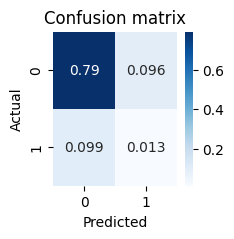

Probability: 0.11
F1 score: 0.12



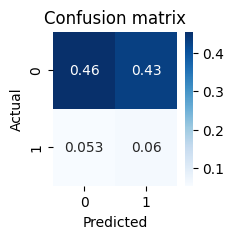

Probability: 0.50
F1 score: 0.20



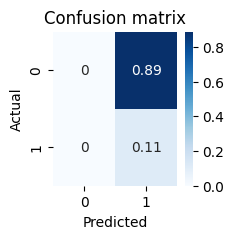

Probability: 1.00
F1 score: 0.20



In [467]:
# Create function to generate random predictions
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

# Test random model
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    target_pred_rnd = rnd_model_predict(P, len(df))    
    f1,_ = eval_classifier(df['insurance_benefits_received'], target_pred_rnd, True)
    print(f'Probability: {P:.2f}')
    print(f'F1 score: {f1:.2f}\n')

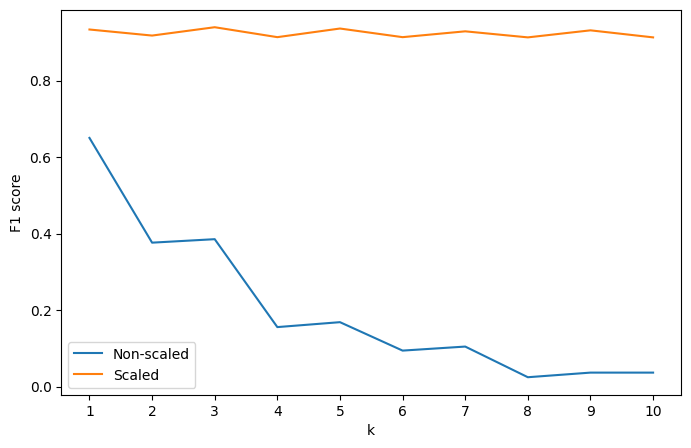

In [468]:
# Test KNN model with non-scaled and scaled data

# Separate features and target
features = df[feature_names].to_numpy()
scaled_features = df_scaled[feature_names].to_numpy()
target = df['insurance_benefits_received'].to_numpy()

# Split the data into training and test sets for both the non-scaled and scaled data
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)
scaled_features_train, scaled_features_test, target_train, target_test = train_test_split(scaled_features, target, test_size=0.3, random_state=42)

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['k', 'f1'])
results_scaled = pd.DataFrame(columns=['k', 'f1'])

# Try different values of k
for k in range(1, 11):
    # Create and train the kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train, target_train)
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(scaled_features_train, target_train)

    # Make predictions on the test set
    predictions = knn.predict(features_test)
    predictions_scaled = knn_scaled.predict(scaled_features_test)

    # Evaluate classifier
    f1 = eval_classifier(target_test, predictions)
    f1_scaled = eval_classifier(target_test, predictions_scaled)

    # Store the results in a DataFrame not using append
    results.loc[k] = [k, f1]
    results_scaled.loc[k] = [k, f1_scaled]

# Create a graph to compare the F1 scores of the non-scaled and scaled data
plt.figure(figsize=(8, 5))
plt.plot(results['k'], results['f1'], label='Non-scaled')
plt.plot(results_scaled['k'], results_scaled['f1'], label='Scaled')
plt.xticks(range(1, 11))
plt.xlabel('k')
plt.ylabel('F1 score')
plt.legend()
plt.show()


## Intermediate Conclusion

- The highest score for the random model would be `0.5`. The results obtained in the KNN model are much better.
- It can be observed that scaled data achieves a higher F1 score compared to non-scaled data for the KNN model.

# Task 3. Linear Regression

Divide all the data corresponding to the training/testing stages respecting the 70:30 ratio. Use the RECM metric to evaluate the model.

In [469]:
# Write example implementation of linear regression so that we can easily obtain the weights
class MyLinearRegression:
    
    def __init__(self):
        
        # Initialize weights to None; these will be computed during the fit process
        self.weights = None
    
    def fit(self, X, y):
        
        # Add a bias column (ones) to the input features
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)

        # Compute weights using the Normal Equation method
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # Add a bias column (ones) to the input features for prediction
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)

        # Return predicted values by multiplying the feature matrix with weights
        return X2 @ self.weights


In [470]:
# Create function to evaluate the model predictions using RMSE and R2
def eval_regressor(target, predictions):
    """Evaluate the predictions of a regressor."""

    # Calculate the RMSE and R2 scores
    rmse = math.sqrt(mean_squared_error(target, predictions))
    r2 = math.sqrt(r2_score(target, predictions))

    return (rmse, r2)

,feature,weight,weight_scaled
0,bias,-9.435390e-01,-0.943539
1,gender,1.642727e-02,0.016427
2,age,3.574955e-02,2.323721
3,income,-2.607437e-07,-0.020599
4,family_members,-1.169021e-02,-0.070141


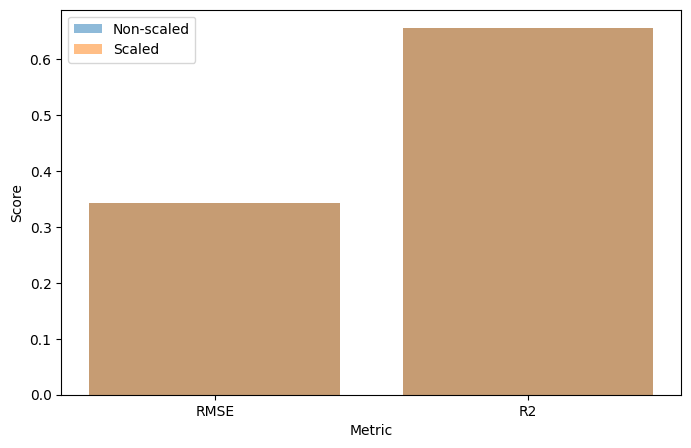

In [471]:
# Test the linear regression model with non-scaled and scaled data
features = df[feature_names].to_numpy()
scaled_features = df_scaled[feature_names].to_numpy()
target = df['insurance_benefits'].to_numpy()

# Split the data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)
scaled_features_train, scaled_features_test, target_train, target_test = train_test_split(scaled_features, target, test_size=0.3, random_state=12345)

# Create and train the linear regression model
lr = MyLinearRegression()
lr_scaled = MyLinearRegression()

lr.fit(features_train, target_train)
lr_scaled.fit(scaled_features_train, target_train)

# Store weights in a DataFrame
weights = pd.DataFrame(
    {
        'feature': ['bias'] + feature_names,
        'weight': lr.weights,
        'weight_scaled': lr_scaled.weights,
    }
)

# Print the weights
display(weights)

# Make predictions on the test set
target_test_pred = lr.predict(features_test)
target_test_pred_scaled = lr_scaled.predict(scaled_features_test)

# Evaluate regressor
rmse, r2 = eval_regressor(target_test, target_test_pred)
rmse_scaled, r2_scaled = eval_regressor(target_test, target_test_pred_scaled)

# Create a graph to compare the RMSE and R2 scores of the non-scaled and scaled data (with transparancy)
plt.figure(figsize=(8, 5))
plt.bar(['RMSE', 'R2'], [rmse, r2], label='Non-scaled', alpha=0.5)
plt.bar(['RMSE', 'R2'], [rmse_scaled, r2_scaled], label='Scaled', alpha=0.5)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend()
plt.show()

## Intermediate Conclusion

- The regression weights for the non-scaled and scaled data are different, which is expected as the scale of the data influences the magnitude of weights in linear regression.
- However, the model performance (measured by RMSE and R2) is essentially the same for both datasets.

# Task 4. Obfuscate data

In [472]:
# Create a list of features for the personal information
personal_info_column_list = ['gender', 'age', 'income', 'family_members']

# Create a DataFrame with the personal information
df_pn = df[personal_info_column_list]

In [473]:
# Save DataFrame as X (numpy array)
X = df_pn.to_numpy()

In [474]:
# Create a random number generator
rng = np.random.default_rng(seed=42)

# Create a random matrix P with the same shape as X
P = rng.random(size=(X.shape[1], X.shape[1]))

In [475]:
# Check that matrix P is invertible
P_inverted = np.linalg.inv(P)
print(P_inverted)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


In [476]:
# Show the obfuscated matrix X
X_obfuscated = X @ P
print(X_obfuscated)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


In [477]:
# Matrix X
print(X)

# Reconstructed matrix X from the obfuscated matrix X
X_original = X_obfuscated @ P_inverted
print(X_original)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]
[[1.00000000e+00 4.10000000e+01 4.96000000e+04 1.00000000e+00]
 [1.64503537e-12 4.60000000e+01 3.80000000e+04 1.00000000e+00]
 [9.25561194e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]
 ...
 [3.87221815e-12 2.00000000e+01 3.39000000e+04 2.00000000e+00]
 [1.00000000e+00 2.20000000e+01 3.27000000e+04 3.00000000e+00]
 [1.00000000e+00 2.80000000e+01 4.06000000e+04 1.00000000e+00]]


In [478]:
# Show data of 3 people in X, X obfuscated, and X reconstructed
for i in range(3):
    print(f'Person {i}')
    print(f'X: {X[i]}')
    print(f'Obfuscated X: {X_obfuscated[i]}')
    print(f'Reconstructed X: {X_original[i]}')
    print()

Person 0
X: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Obfuscated X: [ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
Reconstructed X: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]

Person 1
X: [0.0e+00 4.6e+01 3.8e+04 1.0e+00]
Obfuscated X: [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
Reconstructed X: [1.64503537e-12 4.60000000e+01 3.80000000e+04 1.00000000e+00]

Person 2
X: [    0.    29. 21000.     0.]
Obfuscated X: [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
Reconstructed X: [9.25561194e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]



### Intermediate Conclusion

- It is evident that there are differences between the original and reconstructed values, particularly in instances where the original value was zero. These discrepancies are primarily due to the small rounding errors inherent in floating-point operations. However, the reconstruction process itself is accurate.

## Linear regression test with data obfuscation

,feature,weight,weight_obfuscated
0,bias,-9.435390e-01,-0.943539
1,gender,1.642727e-02,-0.057917
2,age,3.574955e-02,-0.015466
3,income,-2.607437e-07,0.098719
4,family_members,-1.169021e-02,-0.023975


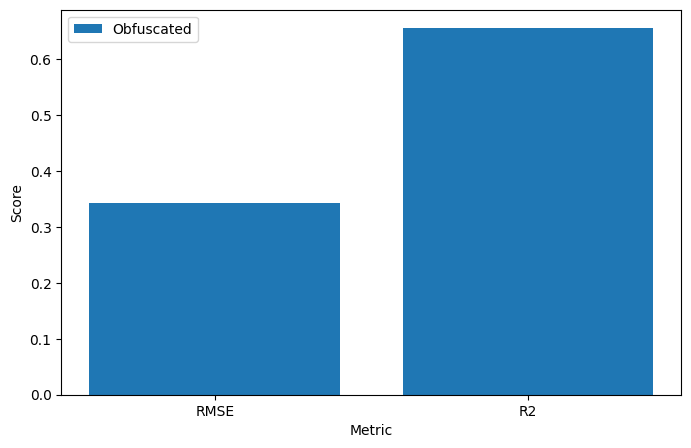

In [479]:
# Test the linear regression model with the obfuscated data
obfuscated_features = X_obfuscated
target = df['insurance_benefits'].to_numpy()

# Split the data into training and test sets
obfuscated_train, obfuscated_test, target_train, target_test = train_test_split(obfuscated_features, target, test_size=0.3, random_state=12345)

# Create and train the linear regression model with the obfuscated data
lr_obfuscated = MyLinearRegression()
lr_obfuscated.fit(obfuscated_train, target_train)

# Store weights in a DataFrame
weights = pd.DataFrame(
    {
        'feature': ['bias'] + personal_info_column_list,
        'weight': lr.weights,
        'weight_obfuscated': lr_obfuscated.weights,
    }
)

# Print the weights
display(weights)

# Make predictions on the test set
target_test_pred = lr_obfuscated.predict(obfuscated_test)

# Evaluate regressor
rmse, r2 = eval_regressor(target_test, target_test_pred)

# Create a graph to compare the RMSE and R2 scores of the non-scaled and scaled data (with transparancy)
plt.figure(figsize=(8, 5))
plt.bar(['RMSE', 'R2'], [rmse, r2], label='Obfuscated')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend()
plt.show()

### Intermediate Conclusion

- The exact same values were obtained in both scores as those obtained for the previous linear regression tests.

# General Conclusion

In this project, we addressed four main tasks related to data analysis and machine learning for the insurance company Sure Tomorrow.

1. We implemented the k-NN algorithm to find similar customers, highlighting the importance of data scaling for optimal performance.

2. We developed a classification model to predict whether a customer would receive an insurance claim. The model proved to be significantly more effective than a random model, indicating its usefulness for the task.

3. We built a linear regression model to forecast the number of insurance claims a customer may receive, confirming that the quality of the model remains consistent regardless of data scaling.

4. We proposed an effective method of data obfuscation that protects customer privacy without compromising the performance of the machine learning model.

In summary, this project demonstrated that it is possible to use machine learning to inform marketing strategies and insurance underwriting decisions while safeguarding customer data privacy.